In [1]:
# import libraries
import time
import pandas as pd
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

In [2]:
alltrainDF = pd.read_json('/home/ravi/PROJECTS_DATA/DataModelsResults/Data/alltrainDF.json', orient = 'records')
trainDF = pd.read_json('/home/ravi/PROJECTS_DATA/DataModelsResults/Data/trainDF.json', orient = 'records')
devDF = pd.read_json('/home/ravi/PROJECTS_DATA/DataModelsResults/Data/devDF.json', orient = 'records')
testDF = pd.read_json('/home/ravi/PROJECTS_DATA/DataModelsResults/Data/testDF.json', orient = 'records')

In [3]:
vectorizer = TfidfVectorizer(encoding='utf-8', lowercase=False, min_df=5,
                                ngram_range=(1, 2), stop_words='english',
                                sublinear_tf=True)

In [4]:
vectorizer.fit(alltrainDF.article)

TfidfVectorizer(lowercase=False, min_df=5, ngram_range=(1, 2),
                stop_words='english', sublinear_tf=True)

In [5]:
pickle.dump(vectorizer.vocabulary_, open("feature.pkl", "wb"))




### alltrain encode

In [6]:
adca saved_vocabulary = pickle.load(open("feature.pkl", 'rb'))
loaded_vectorizer = TfidfVectorizer(encoding='utf-8', lowercase=False, min_df=5,
                                ngram_range=(1, 2), stop_words='english',
                                sublinear_tf=True, vocabulary=saved_vocabulary)

In [10]:
trainVec = loaded_vectorizer.fit_transform(alltrainDF.article)

In [11]:
trainVec.shape

(301715, 6130462)

In [12]:
type(trainVec)

scipy.sparse.csr.csr_matrix

In [13]:
pickle.dump(trainVec, open("alltrainVec.pkl","wb"))

In [35]:
alltrainDF['label'].to_json('alltrainLabelDF.json', orient = 'records')

### test encode

In [18]:
testVec = loaded_vectorizer.fit_transform(testDF.article)

In [19]:
testVec.shape

(75429, 6130462)

In [20]:
type(testVec)

scipy.sparse.csr.csr_matrix

In [21]:
pickle.dump(testVec, open("testVec.pkl","wb"))

In [34]:
testDF['label'].to_json('testLabelDF.json', orient = 'records')

### train encode

In [22]:
trainVec = loaded_vectorizer.fit_transform(trainDF.article)

In [23]:
trainVec.shape

(241372, 6130462)

In [24]:
pickle.dump(trainVec, open("trainVec.pkl","wb"))

In [33]:
trainDF['label'].to_json('trainLabelDF.json', orient = 'records')

### dev encode

In [25]:
devVec = loaded_vectorizer.fit_transform(devDF.article)

In [26]:
devVec.shape

(60343, 6130462)

In [27]:
pickle.dump(devVec, open("devVec.pkl","wb"))

In [32]:
devDF['label'].to_json('devLabelDF.json', orient = 'records')

# TEST

In [15]:
import time
import pickle
import pandas as pd
from thundersvm import SVC
import joblib
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
loaded_SVMmodel = SVC(C=10, gamma=0.1, kernel='rbf', class_weight = 'balanced', random_state = 42)
loaded_SVMmodel.load_from_file('/home/ravi/PROJECTS_DATA/DataModelsResults/Results/SVM/thunderSVMmodel')

In [3]:
testVec = pickle.load(open("/home/ravi/PROJECTS_DATA/DataModelsResults/Data/testVec.pkl", 'rb'))[0:10]
testLabel = pd.read_json('/home/ravi/PROJECTS_DATA/DataModelsResults/Data/testLabelDF.json', orient = 'records').head(10)

In [5]:
y_pred = loaded_SVMmodel.predict(testVec)
print(type(testLabel.values.ravel()), testLabel.values.ravel())
print(type(y_pred), y_pred)

<class 'numpy.ndarray'> [1 2 2 0 2 1 2 0 1 2]
<class 'numpy.ndarray'> [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [6]:
# # save y_pred
test_yTrue_yPred = testLabel.copy()
test_yTrue_yPred["y_pred"]=y_pred
test_yTrue_yPred.to_json('/home/ravi/PROJECTS_DATA/DataModelsResults/Results/SVM/thunderSVM_test_yTrue_yPred.json', orient = 'records')

In [10]:
# # metrics
target_names = ['Liberal', 'Conservative', 'Restricted']
classi_report = classification_report(testLabel.values.ravel(), y_pred, target_names=target_names, digits=4, zero_division=0)
print("classi_report:\n{}".format(classi_report))
print("Testing f1_weighted score: {}".format(f1_score(testLabel.values.ravel(), y_pred, average='weighted')))

classi_report:
              precision    recall  f1-score   support

     Liberal     0.2000    1.0000    0.3333         2
Conservative     0.0000    0.0000    0.0000         3
  Restricted     0.0000    0.0000    0.0000         5

    accuracy                         0.2000        10
   macro avg     0.0667    0.3333    0.1111        10
weighted avg     0.0400    0.2000    0.0667        10

Testing f1_weighted score: 0.06666666666666668


Plot ConfusionMatrix


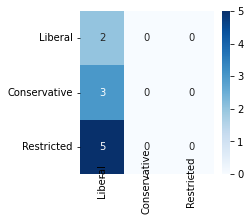

In [16]:
print("Plot ConfusionMatrix")
cm = confusion_matrix(testLabel.values.ravel(), y_pred)
fig, ax = plt.subplots(figsize=(3,3))
display_labels=['Liberal', 'Conservative', 'Restricted']
SVM_ConfusionMatrix = sns.heatmap(cm, annot=True, xticklabels=display_labels, yticklabels=display_labels, cmap='Blues', ax=ax, fmt='d')
plt.yticks(va="center")
plt.xticks(va="center")
fig.savefig('/home/ravi/PROJECTS_DATA/DataModelsResults/Results/SVM/thunderSVM_ConfusionMatrix.png', format='png', dpi=1200, bbox_inches='tight')